## API Class

In [121]:
#-*- coding=utf-8 -*-
from datetime import datetime
import hashlib

class Gemtek_restful_api:
    def __init__(self, URL, api_key, api_secret, macID, index = 0, limit = 10, start_time = 0):
        self.URL = URL
        self.api_key = api_key
        self.api_secret = api_secret
        self.macID = macID
        self.index = index
        self.limit = limit
        self.start_time = start_time
        self.time = str(int(time.time()))
        self.api_token = hashlib.sha1((self.api_secret + self.time).encode('utf-8')).hexdigest()
        self.payload = {
            "index": self.index,
            "start_time" : self.start_time,
            "limit" : self.limit,
            "mac" : self.macID,
            "api_key" : self.api_key,
            "api_token" : self.api_token,
            "time" : self.time
        }
        self.jsonData = None
        self.request_OK = None
        self.jsonDataLength = None
        
        if len(macID) != 12:
            print("mac address is ilegal !!")
        
    def set_query_index(self, index ):
        self.index = index

    def set_query_limit(self, limit ):
        self.limit = limit
        
    def set_query_start_time(self, start_time = 0):
        self.start_time = start_time   

    def set_query_mac(self, macID):
        self.macID = macID  
        
    def print_API_parameter(self):
        print("------------- RESTful API parameter --------------")
        print("mac: ", self.macID)
        print("api_key: ", self.api_key)
        print("api_secret: ", self.api_secret)
        print("unix_time: ", self.time)
        print("api_token: ", self.api_token)
        print("index: ", self.index, "limit: ", self.limit)
        print("Payload:", self.payload)
        print("--------------------------------------------------\n")
        
    def get_query_data(self):    
        req = requests.post(self.URL, json = self.payload)
        self.jsonData = req.json()
        self.jsonDataLength = self.jsonData['value']['total']
        server_ReturnCode = self.jsonData['status']['code']
        server_ReturnMsg = self.jsonData['status']['message']
        
        if (server_ReturnCode == 1200):
            self.request_OK = True
        else:
            self.request_OK = False
        
#         print("------------- Request Status ---------------------")
#         print("Request URL: ", req.url)
#         print("Server return code: ",server_ReturnCode, ", Msg :", server_ReturnMsg)
#         print("Packet Length: ", self.jsonDataLength)
#         print("--------------------------------------------------\n")
     
        return self.jsonData
    
    def update_new_api_token(self):    
        self.time = str(int(time.time()))
        self.api_token = hashlib.sha1((self.api_secret + self.time).encode('utf-8')).hexdigest()
        self.payload["time"] = self.time
        self.payload["api_token"] = self.api_token
    


In [41]:
# lenth = 100
# test_api = Gemtek_restful_api(URL, api_key, api_secret, mac_address1, limit = lenth)
# test_api.print_API_parameter()
# query_JsonData = test_api.get_query_data()

In [42]:
def check_file_path_exist(csvName):
    if not os.path.exists(os.path.dirname(csvName)):
        try:
            os.makedirs(os.path.dirname(csvName))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
                
def get_datetime_from_timeString(date_string):
    date_string = date_string.replace('T',' ').replace('Z','')
    datetime_object = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S.%f')
    return datetime_object

def get_two_datetime_delta(datetime_object1 , datetime_object2):
    datetime_delta   = datetime_object2 - datetime_object1
    return datetime_delta.total_seconds()

In [43]:
def byteToMagData(Low_byte, High_byte):
    value = int(Low_byte.encode(), 16) + int(High_byte.encode(), 16) * 256
    return twos_comp(value, 16)

def twos_comp(val, bits):
    """compute the 2's complement of int value val"""
    if (val & (1 << (bits - 1))) != 0: # if sign bit is set e.g., 8bit: 128-255
        val = val - (1 << bits)        # compute negative value
    return val 

def getPraseTargetData(Data):
    prase_data = Data['value']['hits']
    prase_data_from_json = []
    latency_time_list = list()
    create_time_list  = list()
    
    # columes in data frame
    prase_data_columes = ['_id', '_index', 'mac','create_at_time','recv_at_time','frameCnt', 'data',
                          'company','road','slot_num','gwip','rssi','snr',
                          "timestamp","latency_time","magX", "magY", "magZ","mag_len" ,"magT"]
    TPE_UTC_timestamp = 60*60*8
    # get data by list
    for each in prase_data:
        fullData = []
        pakcetHeader = "fcffff07"
        packetByte = []
        
        fullData = [ each['_id'], each['_index'], each['_source']['macAddr'],
             each['_source']['create_at'], each['_source']['recv'], each['_source']['frameCnt'],
             each['_source']['data'], 
             each['_source']['extra']['company'],  each['_source']['extra']['road'], 
             each['_source']['extra']['slot_num'], each['_source']['gwip'],
             # each['_source']['dataParse']['voltage'], each['_source']['dataParse']['lowBattery'],
             each['_source']['rssi'], each['_source']['snr']
        ]
        
        create_time = get_datetime_from_timeString( each['_source']['create_at'])
        recv_time   = get_datetime_from_timeString( each['_source']['recv'] )
        latency_time = get_two_datetime_delta( recv_time , create_time )
        
        # get high/ low byte
        packetMagData = each['_source']['data']
        
#         if packetMagData.find(pakcetHeader) != -1:
#             index = [i for i in range(len(packetMagData)) if i % 2 == 0]   
#             for each in index:
#                 packetByte.append(packetMagData[each:each+2])
# #             print("packet Byte: ", packetByte)
#         else:
#             print("packet header error")
        
        
        index = [i for i in range(len(packetMagData)) if i % 2 == 0]   
        for each in index:
            packetByte.append(packetMagData[each:each+2])
        
#         print("packet Byte: ", packetByte)
        
        magX = byteToMagData(packetByte[-7], packetByte[-6])
        magY = byteToMagData(packetByte[-5], packetByte[-4])
        magZ = byteToMagData(packetByte[-3], packetByte[-2])
        magT = byteToMagData(packetByte[-1], '00')
        maglen = (magX**2 + magY**2 + magZ**2)**(0.5)

#         print("create_time:", create_time)
#         print("timestamp:", create_time.timestamp())
        fullData.extend([create_time.timestamp() + TPE_UTC_timestamp, latency_time, magX, magY, magZ, maglen, magT])
#         print("Data:", fullData)
        prase_data_from_json.append(fullData)
    return pd.DataFrame(prase_data_from_json, columns=prase_data_columes) 


In [44]:
import time
from datetime import datetime

current_time_obj = time.time()
current_datetime_obj = datetime.fromtimestamp(current_time_obj)
current_time = int(current_time_obj)
print(current_time)

1502333833


In [45]:
# #-*- coding=utf-8 -*-
# import os, sys, errno
# import requests
# import json
# import time
# import hashlib
# import pandas as pd
# from datetime import datetime

# URL = "https://s5.securepilot.com/parking/v1/query_record"
# api_key = "PARK-eMPpua7y17"
# api_secret = "2PHIAGI5qv5IhMGZ56iy"
# folderNmae = os.getcwd() + '/DataBase/'
# testName = folderNmae + 'test'

# mac_gemtek = "101a"
# mac_address1 = mac_gemtek + "0d0100ab"
# mac_address_test = mac_gemtek + "0d01019a"

# mac_query = mac_address1


# ########## API ##################
# parking_api = Gemtek_restful_api(URL, api_key, api_secret, mac_query, index = 0 , limit = 10, start_time = current_time)
# parking_api.print_API_parameter()
# query_JsonData = parking_api.get_query_data()

# # if(parking_api.request_OK):
# #     df = getPraseTargetData(query_JsonData)
# #     NodeName = mac_query
# #     timeName = current_datetime_obj.strftime('%m%d_%H%M%S')
# # #     csvFileName = testName + 'Node_' + NodeName + '_' + timeName + '_' + str(current_time) + '.csv'
# #     csvFileName = testName + 'Node_' + NodeName + '.csv'
# #     check_file_path_exist(csvFileName)
# #     df.to_csv(csvFileName, encoding='utf_8_sig')
# # else:
# #     print("Server Request Fail")


# ########### main ###############
# NodeName = mac_query
# timeName = current_datetime_obj.strftime('%m%d_%H%M%S')
# csvFileName = testName + 'Node_' + NodeName + '.csv'
# csvNewFileName = testName + 'Node_' + NodeName + '_new.csv'
# #     csvFileName = testName + 'Node_' + NodeName + '_' + timeName + '_' + str(current_time) + '.csv'
# check_file_path_exist(csvFileName)
# check_file_path_exist(csvNewFileName)

# # if(parking_api.request_OK):
# #     dfjson = getPraseTargetData(query_JsonData)
# #     dfjson.to_csv(csvFileName, encoding='utf_8_sig')
# # else:
# #     print("Server Request Fail")

# # read old data
# try:
#     dfcsv = pd.read_csv(csvFileName, encoding='utf_8_sig', index_col=0)   
# except:
#     print("csv file doesn't exit")
    
# if(parking_api.request_OK):
#     dfjson = getPraseTargetData(query_JsonData)
#     dfCombineCSV = dfcsv.append(dfjson, ignore_index=True)
#     dfCombineCSV = dfCombineCSV.drop_duplicates(['recv_at_time','create_at_time','gwip'])
#     dfCombineCSV = dfCombineCSV.sort_values(['recv_at_time', 'frameCnt'], ascending=[True, True])
#     dfCombineCSV.to_csv(csvFileName, encoding='utf_8_sig')
# else:
#     print("Server Request Fail")

# print("DB length:",len(dfCombineCSV))


# The_Newest_Time = get_datetime_from_timeString(dfCombineCSV.create_at_time[0])
# The_Newest_Time.timestamp()

In [46]:
# #-*- coding=utf-8 -*-
# import os, sys, errno
# import requests
# import json
# import time
# import hashlib
# import pandas as pd
# from datetime import datetime
# import threading

# URL = "https://s5.securepilot.com/parking/v1/query_record"
# api_key = "PARK-eMPpua7y17"
# api_secret = "2PHIAGI5qv5IhMGZ56iy"
# folderNmae = os.getcwd() + '/DataBase/'
# testName = folderNmae + 'test'

# mac_gemtek = "101a"
# mac_address1 = mac_gemtek + "0d0100ab"
# mac_address_test = mac_gemtek + "0d0100a3"

# mac_query = mac_address1


# ########## API ##################
# parking_api = Gemtek_restful_api(URL, api_key, api_secret, mac_query, index = 0 , limit = 5, start_time = current_time)
# parking_api.print_API_parameter()


# ########### main ###############
# NodeName = mac_query
# timeName = current_datetime_obj.strftime('%m%d_%H%M%S')
# csvFileName = testName + 'Node_' + NodeName + '.csv'
# csvNewFileName = testName + 'Node_' + NodeName + '_new.csv'
# #     csvFileName = testName + 'Node_' + NodeName + '_' + timeName + '_' + str(current_time) + '.csv'
# check_file_path_exist(csvFileName)
# check_file_path_exist(csvNewFileName)


# # read old data
# try:
#     dfcsv = pd.read_csv(csvFileName, encoding='utf_8_sig', index_col=0)   
# except:
#     query_JsonData = parking_api.get_query_data()
#     dfcsv = getPraseTargetData(query_JsonData)
#     print("csv file doesn't exit")

    
# ######################### Query loop ####################   
# def query_AWS_data(dfcsv, enable_threading = False):
#     query_time = 1
#     if enable_threading == True:
#         threading.Timer(3.0, query_AWS_data).start()
    
#     query_JsonData = parking_api.get_query_data()
#     if(parking_api.request_OK):
#         dfjson = getPraseTargetData(query_JsonData)
#         dfCombineCSV = dfcsv.append(dfjson, ignore_index=True)  
#         dfCombineCSV = dfCombineCSV.drop_duplicates(['recv_at_time','create_at_time','gwip'])
#         dfCombineCSV = dfCombineCSV.sort_values(['recv_at_time', 'frameCnt'], ascending=[True, True])
#         dfCombineCSV.to_csv(csvFileName, encoding='utf_8_sig')
#     else:
#         print("Server Request Fail")

#     print("DB length:",len(dfCombineCSV))
    
#     # new timestamp to query
#     The_Newest_Time = get_datetime_from_timeString(dfCombineCSV.create_at_time[0])
#     The_Newest_TimeStamp = The_Newest_Time.timestamp()
#     parking_api.set_query_start_time(str(The_Newest_TimeStamp))
#     print("query_time: ", query_time )


# query_AWS_data(dfcsv)

In [122]:
#-*- coding=utf-8 -*-
import os, sys, errno
import requests
import json
import time
import hashlib
import pandas as pd
from datetime import datetime
import threading

URL = "https://s5.securepilot.com/parking/v1/query_record"
api_key = "PARK-eMPpua7y17"
api_secret = "2PHIAGI5qv5IhMGZ56iy"
folderNmae = os.getcwd() + '/DataBase/Matrix0810_Back/'
testName = folderNmae + 'test'

mac_gemtek = "101a"
mac_address1 = mac_gemtek + "0d0100ab"
mac_address_test = mac_gemtek + "0d0100cc"

# mac_list = ["0d01019a","0d0100cc","0d0100dc","0d0100b5","0d0100dd","0d0100d9","0d0100cb",
#     "0d0100b8","0d0100da","0d010119","0d0101eb","0d0100a3","0d01012a","0d0100e4","0d0100c0", "0d0101e4" ]
mac_list = ["0d01019a","0d0100cc","0d0100dc","0d0100b5","0d0100d9","0d0100cb",
    "0d0100b8","0d0100da","0d010119","0d0101eb","0d0100a3","0d0100e4","0d0100c0", "0d0101e4" ]


mac_query_list = [mac_gemtek + f for f in  mac_list]

########## API ##################
mac_query = mac_query_list[0]
parking_api = Gemtek_restful_api(URL, api_key, api_secret, mac_query, index = 0 , limit = 20, start_time = current_time)
parking_api.print_API_parameter()


######################### Query loop ####################   
def query_AWS_data(dfcsv, enable_threading = False):
    if enable_threading == True:
        threading.Timer(3.0, query_AWS_data).start()
    
    query_JsonData = parking_api.get_query_data()
    if(parking_api.request_OK):
        dfjson = getPraseTargetData(query_JsonData)
        dfCombineCSV = dfcsv.append(dfjson, ignore_index=True)  
        dfCombineCSV = dfCombineCSV.drop_duplicates(['recv_at_time','create_at_time','gwip'])
        dfCombineCSV = dfCombineCSV.sort_values(['recv_at_time', 'frameCnt'], ascending=[True, True])
        dfCombineCSV.to_csv(csvFileName, encoding='utf_8_sig')
    else:
        print("Server Request Fail")

    print("DB length:",len(dfCombineCSV))
    
    # new timestamp to query
    The_Newest_Time = get_datetime_from_timeString(dfCombineCSV.create_at_time[0])
    The_Newest_TimeStamp = The_Newest_Time.timestamp()
    parking_api.set_query_start_time(str(The_Newest_TimeStamp))
    
########### main ###############
query_time = 0

for macID in mac_query_list:

    #mac_query = mac_query_list[-4]
    mac_query = macID
    parking_api.set_query_mac(mac_query)
    NodeName = mac_query
    timeName = current_datetime_obj.strftime('%m%d_%H%M%S')
    csvFileName = testName + 'Node_' + NodeName + '.csv'
    csvNewFileName = testName + 'Node_' + NodeName + '_new.csv'
    #     csvFileName = testName + 'Node_' + NodeName + '_' + timeName + '_' + str(current_time) + '.csv'
    check_file_path_exist(csvFileName)
    check_file_path_exist(csvNewFileName) 
    print("\n\n-------------- mac ID:", mac_query, "----------------")

    # read old data
    query_JsonData = parking_api.get_query_data()
    try:
        dfcsv = pd.read_csv(csvFileName, encoding='utf_8_sig', index_col=0)   
    except:
        if query_JsonData['value']['total'] == 0:
            print("Don't get data")
        else:
            dfcsv = getPraseTargetData(query_JsonData)
        print("csv file doesn't exist, try to create")

        
    if query_JsonData['value']['total'] == 0:
        print("Query ok, but this packet don't contain data", query_JsonData)
    else:
        query_AWS_data(dfcsv, enable_threading = False)
        query_time += 1
        print("query_time: ", query_time )

------------- RESTful API parameter --------------
mac:  101a0d01019a
api_key:  PARK-eMPpua7y17
api_secret:  2PHIAGI5qv5IhMGZ56iy
unix_time:  1502346906
api_token:  48fa7c353e28de79e48e0850ad0c274cf54069d5
index:  0 limit:  20
Payload: {'index': 0, 'start_time': 1502345341, 'limit': 20, 'mac': '101a0d01019a', 'api_key': 'PARK-eMPpua7y17', 'api_token': '48fa7c353e28de79e48e0850ad0c274cf54069d5', 'time': '1502346906'}
--------------------------------------------------



-------------- mac ID: 101a0d01019a ----------------
DB length: 133
query_time:  1


-------------- mac ID: 101a0d0100cc ----------------
DB length: 133
query_time:  2


-------------- mac ID: 101a0d0100dc ----------------
DB length: 134
query_time:  3


-------------- mac ID: 101a0d0100b5 ----------------
DB length: 134
query_time:  4


-------------- mac ID: 101a0d0100d9 ----------------
DB length: 135
query_time:  5


-------------- mac ID: 101a0d0100cb ----------------
DB length: 135
query_time:  6


-------------- m

In [117]:
import time
from datetime import datetime

current_time_obj = time.time()
current_datetime_obj = datetime.fromtimestamp(current_time_obj)
current_time = int(current_time_obj)
print("current unix time: ", current_time)

current unix time:  1502345341


In [102]:
current_time_obj = time.time()
current_datetime_obj = datetime.fromtimestamp(current_time_obj)
current_time = int(current_time_obj)
print("End unix time: ", current_time)

End unix time:  1502344201


In [29]:
from time import gmtime, strftime
strftime("%Y-%m-%d %H:%M:%S", gmtime())

'2017-08-10 02:47:27'

## Data prasing 
 1. lattency

In [75]:
#-*- coding=utf-8 -*-
import requests
import json
import time
import hashlib
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
%matplotlib inline

df = pd.read_csv(csvFileName, encoding='utf_8_sig')
df['date'] = pd.to_datetime(df['timestamp'],unit='s')

count = df['date']
magX = df.magX
magY = df.magY
magZ = df.magZ
magT = df.magT
`
plt.figure()
plt.plot(count, magX, label='magX')
plt.plot(count, magY, label='magY')
plt.plot(count, magZ, label='magZ')
plt.xlabel('Time')
plt.ylabel('Mag Value')
plt.title('Mag data Plot \n ')
plt.legend()
plt.show()

# df2 = pd.DataFrame(np.random.rand(10, 4), columns=['magX', 'magX', 'magX', 'magX'])
# plt.figure(); df2.plot();

SyntaxError: invalid syntax (<ipython-input-75-67367726c2c5>, line 20)

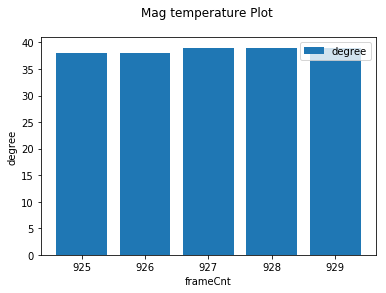

In [741]:
plt.figure()
plt.bar(count, magT, label='degree')
plt.xlabel('frameCnt')
plt.ylabel('degree')
plt.title('Mag temperature Plot \n ')
plt.legend()
plt.show()

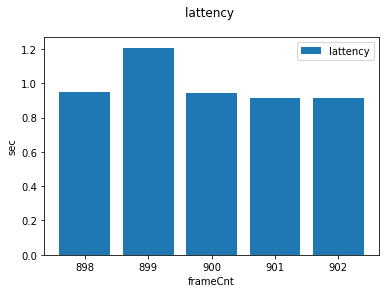

In [718]:
lattency = df.latency_time

plt.figure()
plt.bar(count, lattency, label='lattency')
plt.xlabel('frameCnt')
plt.ylabel('sec')
plt.title('lattency \n ')
plt.legend()
plt.show()

In [ ]:
# latency_time_list = list()
# create_time_list  = list()

# for i in range(len(df.create_at_time)):
#     create_time = get_datetime_from_timeString( df.create_at_time[i] )
#     recv_time   = get_datetime_from_timeString( df.recv_at_time[i] )
#     latency_time = get_two_datetime_delta( recv_time , create_time )
# #     print(latency_time)
#     latency_time_list.append(latency_time)
#     create_time_list.append(latency_time)
    
# df['latency_time'] = latency_time_list

In [45]:
# def get_datetime_from_timeString(date_string):
#     date_string = date_string.replace('T',' ').replace('Z','')
#     datetime_object = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S.%f')
#     return datetime_object

# def get_two_datetime_delta(datetime_object1 , datetime_object2):
#     datetime_delta   = datetime_object2 - datetime_object1
#     return datetime_delta.total_seconds()

# # date_string1 = "2017-07-26 09:04:33.897"
# # date_string2 = "2017-07-26 09:08:33.897"

# # datetime_object1= get_datetime_from_timeString(date_string1)
# # datetime_object2 = get_datetime_from_timeString(date_string2)
# # latency_time = get_two_datetime_delta(datetime_object1,datetime_object2)
# # latency_time